In [ ]:
#%pip install deep_translator

In [ ]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%pip install deep_translator
from deep_translator import GoogleTranslator
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.3 MB/s eta 0:00:00


In [ ]:
# Initialize NLP tools
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def translate_text(text, dest_language='en'):
    try:
        translator = GoogleTranslator(target=dest_language)
        return translator.translate(text)
    except Exception as e:
        print(f"Error in translation: {e}")
        return text

In [ ]:
def analyze_sentiments(posts):
    results = []
    for index, row in posts.iterrows():
        title = row['Title']
        sentiment_score = sia.polarity_scores(row['Translated_Content'])  # Directly use translated content
        time = row['Date']
        results.append((title, sentiment_score, time))

    return results


In [ ]:
new_words = {
    'market downturn': -3,
    'disaster': -3,
    'earthquake': -3,
    'lowest record': -3,
    'worst weekly performance': -3,  # Newly added, indicates poor market performance
    'worst workplace environment': -3,
    'rigid hierarchy': -3,
    'liver-selling culture': -3,
    'downward revision of industry outlook': -3,
    'selling pressure on semiconductor group': -3,
    'power shortage': -3,
    'ADR fell again': -3,
    'Huida plunged 10%': -3,
    'strategic mistake': -3,
    'be so stupid?': -3,
    'overcapacity': -2,
    'manpower shortage': -2,
    'can no longer raise wages': -2,
    'market nervous': -2,
    'talent shortage': -2,
    'labor disputes': -2,
    'expansion postponed': -2,
    'difficulty attracting talents': -2,
    'limitation in salary increases': -2,
    'rejects some new cases': -2,
    'half-baked state': -2,
    'competitive threat': -2,
    'industry decline': -2,
    'net profit decrease': -2,
    'mature manufacturing processes under attack': -2,
    'factories facing challenges': -2,
    'price killing of mature processes': -2,
    "attack from China's production capacity": -2,
    'working overtime for no reason': -2,
    'cultural differences': -1,
    'no free lunch': -1,
    'language barriers': -1,
    'misalignment with local norms': -1,
    'lacks international certification': -1,
    'inflation concerns': -1,  # Newly added, reflects economic concerns
    'questioning': -1,
    'surprise': 1,
    'job briefing session': 1,
    'training facility': 1,
    'curious about future and remuneration': 1,
    'teaching at parent-teacher conference': 1,
    'reform meeting': 1,
    'short-term correction': 1,
    'resilience in operations': 2,
    'shot in the arm': 2,
    'higher hourly wages': 2,
    'competitive with large banks': 2,
    'raised salary': 2,
    'performance bonuses': 2,
    'record high': 2,
    'competitive salary': 2,
    'wonderful fruits': 2,
    'generous salary': 2,
    'protected platform': 2,
    'popular employment location': 2,
    'annual salary increase': 2,
    'long-term growth prospects': 3,
    'innovation in silicon photonics': 3,
    'chip shortage': 3,
    'pillar that protects': 3,
    'employment boom': 3,
    'EPS growth': 3,
    'strong market demand': 3,
    'target price exceeds': 3,
    'mass production of the 3-nanometer process': 3,
    'addition of AI applications': 3,
    'expected re-rate': 3
}

# 更新詞典
sia.lexicon.update(new_words)

In [ ]:
def scrape_ptt_stock_board(pages=500):
    url = "https://www.ptt.cc/bbs/Stock/index.html"
    headers = {'User-Agent': 'Mozilla/5.0'}
    posts = []

    for _ in range(pages):
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")

        for item in soup.find_all("div", class_="r-ent"):
            title_tag = item.find("div", class_="title").a
            if title_tag:  # Ensure the title exists
                title = title_tag.text
                if '台積電' in title and '[新聞]' in title and 'Re:' not in title and '張淑芬' not in title and '薪' not in title:  # Check if '台積電' is in the title
                    link = "https://www.ptt.cc" + title_tag['href']
                    date = item.find("div", class_="date").text.strip()


                    # Since the title contains '台積電', fetch the content of the post
                    content_response = requests.get(link, headers=headers)
                    content_soup = BeautifulSoup(content_response.text, "html.parser")
                    content = content_soup.find(id="main-content").text

                    meta_value = content_soup.find_all("span", class_="article-meta-value")
                    if meta_value:
                        date = meta_value[-1].text.strip()
                        date_obj = datetime.strptime(date, '%a %b %d %H:%M:%S %Y')
                        formatted_date = date_obj.strftime('%Y-%m-%d')
                        date = formatted_date


                    # Remove metadata and menu from content
                    content = content.split('--')[0].split()  # This assumes that the content and the metadata are separated by '--'

                    # Combine title and content
                    Title=   f"Title: {title}"
                    full_text  = f"Content:{title}{content}"
                    posts.append((Title,date,full_text))

        # Find the link to the previous page
        prev_link = soup.find("a", string="‹ 上頁")  # The text for "previous page" might vary due to encoding
        if prev_link:
            url = "https://www.ptt.cc" + prev_link['href']
        else:
            break  # Stop if no previous page link is found

    return posts



In [ ]:
# Using the function
posts_data = scrape_ptt_stock_board()

In [ ]:
data = pd.DataFrame(columns=['Title', 'Date', 'Content', 'Translated_Content'], index=range(len(posts_data)))
current_year = datetime.now().year
t=0

for post in posts_data:
    data.iloc[t, 0] = post[0]
    data.iloc[t, 1] = post[1]
    text=''
    for post in post[2]:
        text=text+post
    data.iloc[t,2]=text
    data.iloc[t,3]=translate_text(text)
    t=t+1
data

Error in translation: Request exception can happen due to an api connection error. Please check your connection and try again
Error in translation: Request exception can happen due to an api connection error. Please check your connection and try again
Error in translation: Request exception can happen due to an api connection error. Please check your connection and try again


,Title,Date,Content,Translated_Content
0,Title: [新聞] AI帶動供不應求 台積電今年3奈米產,2024-05-23,"Content:[新聞] AI帶動供不應求 台積電今年3奈米產['作者kech9111', ...",Content: [News] AI drives supply to exceed dem...
1,Title: [新聞] 無懼大陸軍演！台股漲逾百點創新高 台積電,2024-05-23,Content:[新聞] 無懼大陸軍演！台股漲逾百點創新高 台積電['作者joanzkow'...,Content:[News] Don’t be afraid of mainland mil...
2,Title: [新聞] 台積電下車潮 股民連3周下滑 7.8萬人離場,2024-05-18,Content:[新聞] 台積電下車潮 股民連3周下滑 7.8萬人離場['作者kiverso...,"Content: [News] TSMC's exit trend saw 78,000 s..."
3,Title: [新聞] 台積電準備HBM4基礎晶片生產,2024-05-17,"Content:[新聞] 台積電準備HBM4基礎晶片生產['作者howardcb', '(我...",Content:[News] TSMC prepares for HBM4 basic wa...
4,Title: [新聞] 台積電飆855元全賣了！他爽賺213萬離場,2024-05-17,Content:[新聞] 台積電飆855元全賣了！他爽賺213萬離場 ['作者icedog1...,Content:[News] TSMC sold out for 855 yuan! He ...
...,...,...,...,...
208,Title: [新聞] 台積電先進製程遭「洩漏給男友」 女副理,2024-01-05,Content:[新聞] 台積電先進製程遭「洩漏給男友」 女副理['作者icedog122'...,Content:[News] TSMC's advanced manufacturing p...
209,Title: [新聞] 雙王法說將登場 外資先升台積電目標價,2024-01-03,Content:[新聞] 雙王法說將登場 外資先升台積電目標價['作者DrowningPoo...,Content: [News] The law of two kings will appe...
210,Title: [新聞] 最新中國市值500強: 台積電重奪榜首,2024-01-03,Content:[新聞] 最新中國市值500強: 台積電重奪榜首['作者TeddyisaBe...,Content: [News] The latest top 500 companies i...
211,Title: [新聞] 台積電1/18辦實體法說 內外資喊目標價700,2024-01-02,Content:[新聞] 台積電1/18辦實體法說 內外資喊目標價700['作者Drowni...,Content: [News] TSMC 1/18 passed the entity la...


In [ ]:
# Assuming 'filtered_posts' needs to be obtained from 'data'
sentiment_results = analyze_sentiments(data)
#print(sentiment_results)

In [ ]:
t=0
for title, sentiment, date in sentiment_results:
    try:
        # Store the formatted date and sentiment scores in the DataFrame
        data.loc[t, 'Date'] = date
        data.loc[t, 'neg'] = sentiment['neg']
        data.loc[t, 'neu'] = sentiment['neu']
        data.loc[t, 'pos'] = sentiment['pos']
        data.loc[t, 'compound'] = sentiment['compound']

        t += 1  # Update the index for next use

    except ValueError as ve:
        print(f"Error parsing date {date}: {ve}")



In [ ]:
# Convert 'Date' column to datetime format, only keeping the date part
data.dropna(axis=0,inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# Print DataFrame to check results
print(data[['Date', 'neg', 'neu', 'pos', 'compound']])

          Date    neg    neu    pos  compound
0   2024-05-23  0.038  0.962  0.000   -0.1280
1   2024-05-23  0.000  1.000  0.000    0.0000
2   2024-05-18  0.026  0.928  0.046    0.4007
3   2024-05-17  0.008  0.893  0.099    0.9952
4   2024-05-17  0.055  0.823  0.122    0.9891
..         ...    ...    ...    ...       ...
208 2024-01-05  0.086  0.821  0.093    0.3487
209 2024-01-03  0.013  0.914  0.073    0.9672
210 2024-01-03  0.032  0.827  0.142    0.9982
211 2024-01-02  0.013  0.877  0.110    0.9969
212 2023-12-28  0.000  1.000  0.000    0.0000

[213 rows x 5 columns]


In [ ]:
# Assuming the current year for the date
start_date = min(data['Date'])

# Print the date object
print(start_date)

today_date = datetime.now().date()
today_date= pd.to_datetime(today_date)
print(today_date)

2023-12-28 00:00:00
2024-05-23 00:00:00


In [ ]:
stockdata = yf.download("2330.tw", start=start_date, end=today_date)
stockdata.index = stockdata.index.date
stockdata.index = pd.to_datetime(stockdata.index)
stockdata

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2023-12-28,592.0,593.0,589.0,593.0,590.243835,25514849
2023-12-29,589.0,593.0,589.0,593.0,590.243835,18416318
2024-01-02,590.0,593.0,589.0,593.0,590.243835,26059058
2024-01-03,584.0,585.0,576.0,578.0,575.313599,37106763
2024-01-04,580.0,581.0,577.0,580.0,577.304260,15309129
...,...,...,...,...,...,...
2024-05-16,852.0,856.0,837.0,841.0,841.000000,43927195
2024-05-17,848.0,848.0,834.0,835.0,835.000000,26207289
2024-05-20,834.0,838.0,822.0,835.0,835.000000,28808661
2024-05-21,830.0,841.0,830.0,841.0,841.000000,19705349


In [ ]:
# Ensure the stock data index is set correctly
stockdata.index = pd.to_datetime(stockdata.index)
data['Trading Date']=0
# Creating Trading Date
t=0
for date in data['Date']:
    if date in stockdata.index:
       data.iloc[t,8]=date
    t=t+1
data.sort_values('Date',ascending=False,inplace=True)


In [ ]:
t=0
for date in data['Date']:
    if data.iloc[t,8]==0 and t<len(data['Date']):
       data.iloc[t,8]=data.iloc[t-1,8]
    t=t+1
data.dropna(inplace=True)

In [ ]:
#for content in data['Translated_Content']:
  #print(content)

In [ ]:
sentiment_df = data.groupby('Trading Date').agg({
    'Title': 'count',  # 计算每日帖子数量
    'neg': 'mean',
    'neu': 'mean',
    'pos': 'mean',
    'compound': 'mean'
})

sentiment_df

,Title,neg,neu,pos,compound
Trading Date,,,,,
2023-12-28,4,0.016000,0.972500,0.011500,0.068175
2024-01-02,1,0.013000,0.877000,0.110000,0.996900
2024-01-03,2,0.022500,0.870500,0.107500,0.982700
2024-01-05,2,0.062000,0.831500,0.106500,0.657600
2024-01-11,3,0.021333,0.902000,0.076667,0.937600
...,...,...,...,...,...
2024-05-10,2,0.002500,0.877000,0.120500,0.868150
2024-05-14,3,0.017333,0.886333,0.096333,0.849900
2024-05-15,2,0.032500,0.871500,0.096000,0.395300


In [ ]:
# Merge on the date index
combined_df = pd.merge(sentiment_df, stockdata, left_index=True, right_index=True, how='left')
# 計算價差
combined_df['price_diff'] = combined_df['Close'].diff()
# Assuming 'df' is your DataFrame
combined_df.dropna(inplace=True)
combined_df

,Title,neg,neu,pos,compound,Open,High,Low,Close,Adj Close,Volume,price_diff
Trading Date,,,,,,,,,,,,
2024-01-02,1,0.013000,0.877000,0.110000,0.996900,590.0,593.0,589.0,593.0,590.243835,26059058,0.0
2024-01-03,2,0.022500,0.870500,0.107500,0.982700,584.0,585.0,576.0,578.0,575.313599,37106763,-15.0
2024-01-05,2,0.062000,0.831500,0.106500,0.657600,578.0,580.0,574.0,576.0,573.322876,18158971,-2.0
2024-01-11,3,0.021333,0.902000,0.076667,0.937600,586.0,589.0,583.0,586.0,583.276367,23997409,10.0
2024-01-15,2,0.032500,0.849000,0.119000,0.976350,590.0,590.0,585.0,586.0,583.276367,21143076,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10,2,0.002500,0.877000,0.120500,0.868150,803.0,807.0,798.0,802.0,802.000000,25101318,6.0
2024-05-14,3,0.017333,0.886333,0.096333,0.849900,816.0,825.0,811.0,825.0,825.000000,28691846,23.0
2024-05-15,2,0.032500,0.871500,0.096000,0.395300,838.0,844.0,837.0,839.0,839.000000,39467772,14.0


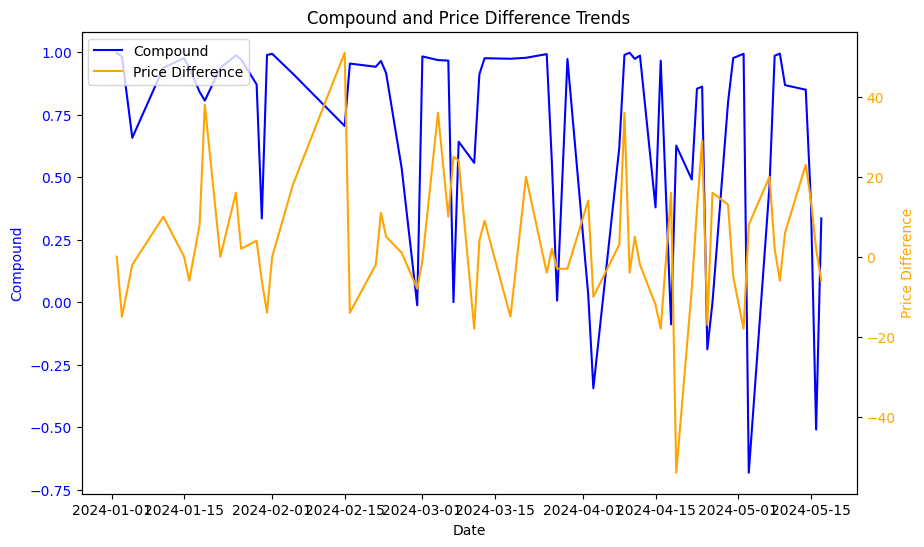

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# 繪製'compound'欄位的折線圖
ax1.plot(combined_df.index, combined_df['compound'], label='Compound', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Compound', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Compound and Price Difference Trends')

# 建立第二個軸對象，共享x軸
ax2 = ax1.twinx()
ax2.plot(combined_df.index, combined_df['price_diff'], label='Price Difference', color='orange')
ax2.set_ylabel('Price Difference', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 添加圖例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.show()

In [ ]:
# 確保'compound'和'price_diff'欄位的資料類型為數值型
combined_df['compound'] = pd.to_numeric(combined_df['compound'], errors='coerce')
combined_df['price_diff'] = pd.to_numeric(combined_df['price_diff'], errors='coerce')

# 移除可能存在的NaN值
combined_df = combined_df.dropna()

# 計算'compound'和'price_diff'之間的相關係數
correlation = combined_df['compound'].corr(combined_df['price_diff'])

print(f"相關係數: {correlation}")

相關係數: 0.025918999763089798
